In [2]:
!wget http://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip ml-1m.zip

--2025-05-14 15:58:03--  http://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip.1’

ml-1m.zip.1         100%[===================>]   5.64M  23.6MB/s    in 0.2s    

2025-05-14 15:58:03 (23.6 MB/s) - ‘ml-1m.zip.1’ saved [5917549/5917549]

Archive:  ml-1m.zip
replace ml-1m/movies.dat? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ml-1m/movies.dat        
replace ml-1m/ratings.dat? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ml-1m/ratings.dat       
replace ml-1m/README? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ml-1m/README            
replace ml-1m/users.dat? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ml-1m/users.dat         


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [7]:
ratings = pd.read_csv(
    'ml-1m/ratings.dat',
    sep='::',
    engine='python',
    names=['UserID', 'MovieID', 'Rating', 'Timestamp']
)

In [8]:
movies = pd.read_csv(
    'ml-1m/movies.dat',
    sep='::',
    engine='python',
    names=['MovieID', 'Title', 'Genres'],
    encoding='latin-1'  # or 'iso-8859-1'
)

In [9]:
users = pd.read_csv(
    'ml-1m/users.dat',
    sep='::',
    engine='python',
    names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code']
)

In [10]:
ratings.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [11]:
movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [12]:
users.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [13]:
data = pd.merge(ratings, movies, on='MovieID')
data = pd.merge(data, users, on='UserID')

In [14]:
data.head()

,UserID,MovieID,Rating,Timestamp,Title,Genres,Gender,Age,Occupation,Zip-code
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama,F,1,10,48067
1,1,661,3,978302109,James and the Giant Peach (1996),Animation|Children's|Musical,F,1,10,48067
2,1,914,3,978301968,My Fair Lady (1964),Musical|Romance,F,1,10,48067
3,1,3408,4,978300275,Erin Brockovich (2000),Drama,F,1,10,48067
4,1,2355,5,978824291,"Bug's Life, A (1998)",Animation|Children's|Comedy,F,1,10,48067


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 10 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   UserID      1000209 non-null  int64 
 1   MovieID     1000209 non-null  int64 
 2   Rating      1000209 non-null  int64 
 3   Timestamp   1000209 non-null  int64 
 4   Title       1000209 non-null  object
 5   Genres      1000209 non-null  object
 6   Gender      1000209 non-null  object
 7   Age         1000209 non-null  int64 
 8   Occupation  1000209 non-null  int64 
 9   Zip-code    1000209 non-null  object
dtypes: int64(6), object(4)
memory usage: 76.3+ MB


In [16]:
data.isna().sum()

,0
UserID,0
MovieID,0
Rating,0
Timestamp,0
Title,0
Genres,0
Gender,0
Age,0
Occupation,0
Zip-code,0


<Axes: ylabel='Frequency'>

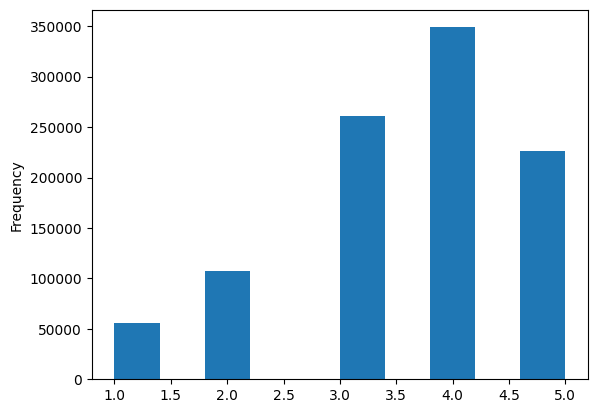

In [17]:
data['Rating'].plot(kind='hist')

In [18]:
data.nunique()

,0
UserID,6040
MovieID,3706
Rating,5
Timestamp,458455
Title,3706
Genres,301
Gender,2
Age,7
Occupation,21
Zip-code,3439


In [19]:
age_group_counts = data.groupby('Age').size()
print(age_group_counts)

Age
1      27211
18    183536
25    395556
35    199003
45     83633
50     72490
56     38780
dtype: int64


### Age column is binned, so I will treat each as a respective group i.e '1' will be analyzed as '<18','18' will be '18-24','25' will be '25-34','35' will be '35-44', '45' will be '45-49', '50' will be '50-55', and '56' will be '56+'


In [20]:
## Theory: Time of day may effect genre/rating of movie.

data['Hour'] = pd.to_datetime(data['Timestamp'], unit='s').dt.hour
data.head()

,UserID,MovieID,Rating,Timestamp,Title,Genres,Gender,Age,Occupation,Zip-code,Hour
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama,F,1,10,48067,22
1,1,661,3,978302109,James and the Giant Peach (1996),Animation|Children's|Musical,F,1,10,48067,22
2,1,914,3,978301968,My Fair Lady (1964),Musical|Romance,F,1,10,48067,22
3,1,3408,4,978300275,Erin Brockovich (2000),Drama,F,1,10,48067,22
4,1,2355,5,978824291,"Bug's Life, A (1998)",Animation|Children's|Comedy,F,1,10,48067,23


In [21]:
#Extract Year out of Title column and update Title column
data['Year'] = data['Title'].str[-5:-1]
data['Title'] = data['Title'].str[:-7]
data.head()

,UserID,MovieID,Rating,Timestamp,Title,Genres,Gender,Age,Occupation,Zip-code,Hour,Year
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest,Drama,F,1,10,48067,22,1975
1,1,661,3,978302109,James and the Giant Peach,Animation|Children's|Musical,F,1,10,48067,22,1996
2,1,914,3,978301968,My Fair Lady,Musical|Romance,F,1,10,48067,22,1964
3,1,3408,4,978300275,Erin Brockovich,Drama,F,1,10,48067,22,2000
4,1,2355,5,978824291,"Bug's Life, A",Animation|Children's|Comedy,F,1,10,48067,23,1998


In [22]:
#Convert Gender into binary representation
data['Gender'] = data['Gender'].replace({'M': 1, 'F': 0})
data.head()

<ipython-input-22-da4fff86ff7f>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Gender'] = data['Gender'].replace({'M': 1, 'F': 0})


,UserID,MovieID,Rating,Timestamp,Title,Genres,Gender,Age,Occupation,Zip-code,Hour,Year
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest,Drama,0,1,10,48067,22,1975
1,1,661,3,978302109,James and the Giant Peach,Animation|Children's|Musical,0,1,10,48067,22,1996
2,1,914,3,978301968,My Fair Lady,Musical|Romance,0,1,10,48067,22,1964
3,1,3408,4,978300275,Erin Brockovich,Drama,0,1,10,48067,22,2000
4,1,2355,5,978824291,"Bug's Life, A",Animation|Children's|Comedy,0,1,10,48067,23,1998


In [23]:
#Convert occupation into one-hot representations to avoid ordinal/magnitude assumptions by model later on in development
occupation_dummies = pd.get_dummies(data['Occupation'], prefix='Occupation')
data = pd.concat([data, occupation_dummies], axis=1)
data.head()

,UserID,MovieID,Rating,Timestamp,Title,Genres,Gender,Age,Occupation,Zip-code,...,Occupation_11,Occupation_12,Occupation_13,Occupation_14,Occupation_15,Occupation_16,Occupation_17,Occupation_18,Occupation_19,Occupation_20
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest,Drama,0,1,10,48067,...,False,False,False,False,False,False,False,False,False,False
1,1,661,3,978302109,James and the Giant Peach,Animation|Children's|Musical,0,1,10,48067,...,False,False,False,False,False,False,False,False,False,False
2,1,914,3,978301968,My Fair Lady,Musical|Romance,0,1,10,48067,...,False,False,False,False,False,False,False,False,False,False
3,1,3408,4,978300275,Erin Brockovich,Drama,0,1,10,48067,...,False,False,False,False,False,False,False,False,False,False
4,1,2355,5,978824291,"Bug's Life, A",Animation|Children's|Comedy,0,1,10,48067,...,False,False,False,False,False,False,False,False,False,False


In [24]:
#Extract first 3 numbers from zipcode and convert to one-hot representation. Retains approximate geographic regions which may help model performance, but reduces dimensionality of using full zipcode
data['ZipPrefix'] = data['Zip-code'].str[:3]
zip_dummies = pd.get_dummies(data['ZipPrefix'], prefix='Zip')
data = pd.concat([data.drop(['Zip-code'], axis=1), zip_dummies], axis=1)
data.head()

,UserID,MovieID,Rating,Timestamp,Title,Genres,Gender,Age,Occupation,Hour,...,Zip_988,Zip_989,Zip_990,Zip_991,Zip_992,Zip_993,Zip_995,Zip_997,Zip_998,Zip_999
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest,Drama,0,1,10,22,...,False,False,False,False,False,False,False,False,False,False
1,1,661,3,978302109,James and the Giant Peach,Animation|Children's|Musical,0,1,10,22,...,False,False,False,False,False,False,False,False,False,False
2,1,914,3,978301968,My Fair Lady,Musical|Romance,0,1,10,22,...,False,False,False,False,False,False,False,False,False,False
3,1,3408,4,978300275,Erin Brockovich,Drama,0,1,10,22,...,False,False,False,False,False,False,False,False,False,False
4,1,2355,5,978824291,"Bug's Life, A",Animation|Children's|Comedy,0,1,10,23,...,False,False,False,False,False,False,False,False,False,False


In [25]:
data['ZipPrefix'].nunique()

678

In [26]:
#Converting Genres into one-hot encodings. To get a general understanding of features that effect model performance I will start with one-hot representation,
#but may need to use embeddings to figure out genre relationships, but will use one-hot as preliminary representation/
genre_dummies = data['Genres'].str.get_dummies(sep='|')
data = pd.concat([data.drop('Genres', axis=1), genre_dummies], axis=1)
data.head()

,UserID,MovieID,Rating,Timestamp,Title,Gender,Age,Occupation,Hour,Year,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest,0,1,10,22,1975,...,0,0,0,0,0,0,0,0,0,0
1,1,661,3,978302109,James and the Giant Peach,0,1,10,22,1996,...,0,0,0,1,0,0,0,0,0,0
2,1,914,3,978301968,My Fair Lady,0,1,10,22,1964,...,0,0,0,1,0,1,0,0,0,0
3,1,3408,4,978300275,Erin Brockovich,0,1,10,22,2000,...,0,0,0,0,0,0,0,0,0,0
4,1,2355,5,978824291,"Bug's Life, A",0,1,10,23,1998,...,0,0,0,0,0,0,0,0,0,0


In [27]:
print('\nTitles with more than 50 tokens:', data[data['Title'].str.len().gt(50)].shape[0])


Titles with more than 50 tokens: 5995


Text(0.5, 0, 'Number of tokens per Title')

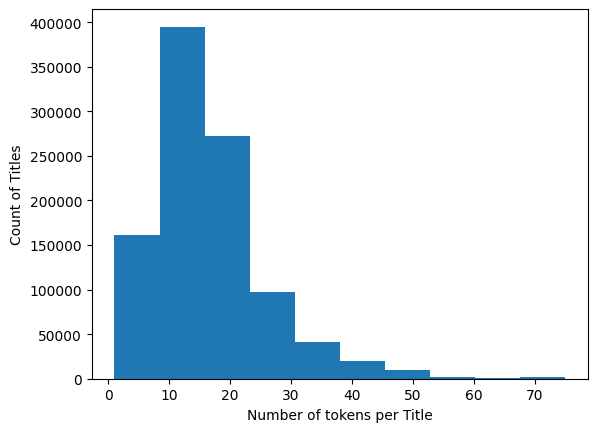

In [28]:
plt.hist(data['Title'].str.len());
plt.ylabel('Count of Titles')
plt.xlabel('Number of tokens per Title')

In [29]:
data['Title'].str.len().max()

75

In [30]:
data['MovieID'].nunique()
data['MovieID'].sort_values()

,MovieID
707867,1
94510,1
439765,1
860768,1
3847,1
...,...
258260,3952
456022,3952
236581,3952
207669,3952


Starting with simple input_length of using MovieID

In [31]:
input_dimension = (data['MovieID'].nunique()) + 1
output_dimension = int(math.ceil(math.log2(input_dimension)))
input_length = 1

embeddings = tf.keras.layers.Embedding(
    input_dim = input_dimension,  # size of feature vocabulary
    output_dim = output_dimension ,   # embedding dimension
    input_length = input  # number of inputs
    )

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [32]:
d = tf.constant([1], shape=(1, 1))
embed_data = embeddings(d)
print(embed_data.numpy())

[[[-0.00312816  0.03783682 -0.01493009  0.03585831 -0.03206002
   -0.03132622 -0.04874615  0.03121377 -0.02219133 -0.04687805
    0.01444442 -0.04690368]]]


In [33]:
embedding_vector = tf.squeeze(embed_data)
embedding_vector

<tf.Tensor: shape=(12,), dtype=float32, numpy=
array([-0.00312816,  0.03783682, -0.01493009,  0.03585831, -0.03206002,
       -0.03132622, -0.04874615,  0.03121377, -0.02219133, -0.04687805,
        0.01444442, -0.04690368], dtype=float32)>

In [34]:
### Add vectorization layer when coming back and doing title embeddings